# Emotion Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from math import ceil

In [2]:
train = True
model_path = '../models/'
save_model_name = 'model.h5'
load_model_name = None

In [3]:
data = pd.read_csv('../data/fer2013.csv')
labels = pd.read_csv('../data/fer2013new.csv')

orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
                    'disgust', 'fear', 'contempt','unknown', 'NF']

n_samples = len(data)
w = 48
h = 48

y = np.array(labels[orig_class_names])
X = np.zeros((n_samples, w, h, 1))
for i in range(n_samples):
    X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

In [4]:
orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 
                    'disgust', 'fear', 'contempt', 'unknown', 'NF']

# Using mask to remove unknown or NF images
y_mask = y.argmax(axis=-1)
mask = y_mask < orig_class_names.index('unknown')
X = X[mask]
y = y[mask]

# Convert to probabilities between 0 and 1
y = y[:, :-2] * 0.1

# Add contempt to neutral and remove it
y[:, 0] += y[:, 7]
y = y[:, :7]

# Normalize image vectors
X = X / 255.0

In [5]:
test_size = ceil(len(X) * 0.1)

# Split Data
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=42)

x_train, x_val, y_train, y_val = train_test_split(x_train, 
                                                  y_train, 
                                                  test_size=test_size, 
                                                  random_state=42)

In [6]:
shift = 0.1
datagen = ImageDataGenerator(rotation_range=20,
                             horizontal_flip=True,
                             height_shift_range=shift,
                             width_shift_range=shift)

datagen.fit(x_train)

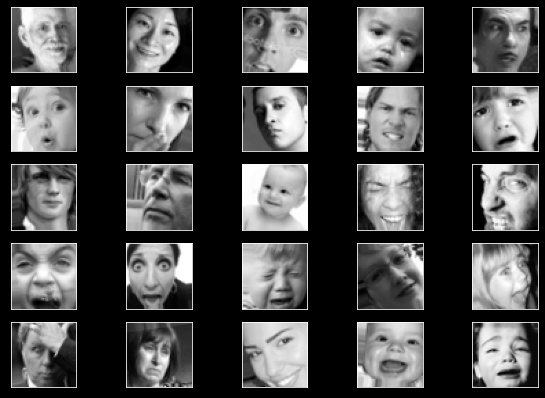

In [7]:
it = datagen.flow(x_train, y_train, batch_size=1)
plt.figure(figsize=(10, 7))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(it.next()[0][0], cmap='gray')

plt.show()

In [8]:
epochs = 50
batch_size = 64

print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)


In [9]:
if load_model_name:
    model = load_model(model_path + load_model_name)
    
else:
    model = Sequential()

    # 1st layer
    model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(64, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.5))

    # 2nd layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 3rd layer
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    # 4th layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 5th layer
    model.add(Conv2D(256, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    model.add(Flatten())

    # Fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(7, activation='softmax'))

model.summary()
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 44, 44, 64)        0

In [10]:
train_progress = None

if train:
    early_stopping = EarlyStopping(monitor='accuracy',
                                   min_delta=0.00005,
                                   patience=32,
                                   verbose=2,
                                   restore_best_weights=True)
    
    train_progress = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), 
                               epochs=epochs, 
                               steps_per_epoch=len(x_train) // batch_size, 
                               validation_data=(x_val, y_val), 
                               verbose=2,
                               callbacks=[early_stopping])
    
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

Epoch 1/50
443/443 - 50s - loss: 0.3430 - accuracy: 0.4249 - val_loss: 0.3763 - val_accuracy: 0.3793
Epoch 2/50
443/443 - 41s - loss: 0.3027 - accuracy: 0.5489 - val_loss: 0.2746 - val_accuracy: 0.6174
Epoch 3/50
443/443 - 38s - loss: 0.2790 - accuracy: 0.6079 - val_loss: 0.2572 - val_accuracy: 0.6568
Epoch 4/50
443/443 - 37s - loss: 0.2639 - accuracy: 0.6427 - val_loss: 0.2673 - val_accuracy: 0.6320
Epoch 5/50
443/443 - 39s - loss: 0.2529 - accuracy: 0.6681 - val_loss: 0.2375 - val_accuracy: 0.7013
Epoch 6/50
443/443 - 39s - loss: 0.2456 - accuracy: 0.6849 - val_loss: 0.2388 - val_accuracy: 0.6954
Epoch 7/50
443/443 - 40s - loss: 0.2388 - accuracy: 0.7002 - val_loss: 0.2424 - val_accuracy: 0.6850
Epoch 8/50
443/443 - 41s - loss: 0.2335 - accuracy: 0.7161 - val_loss: 0.2244 - val_accuracy: 0.7473
Epoch 9/50
443/443 - 40s - loss: 0.2289 - accuracy: 0.7256 - val_loss: 0.2298 - val_accuracy: 0.7132
Epoch 10/50
443/443 - 40s - loss: 0.2257 - accuracy: 0.7337 - val_loss: 0.2345 - val_accura

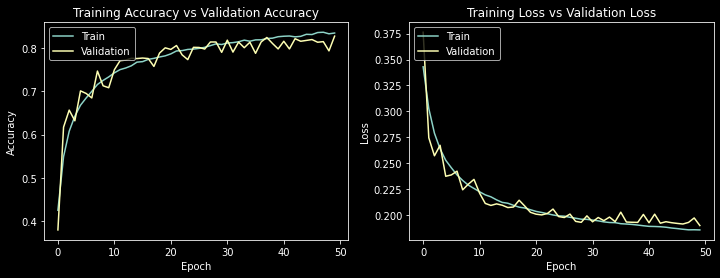

In [11]:
if train_progress:
    fig, ax = plt.subplots(1, 2)
    train_acc = train_progress.history['accuracy']
    train_loss = train_progress.history['loss']
    fig.set_size_inches(12, 4)

    ax[0].plot(train_progress.history['accuracy'])
    ax[0].plot(train_progress.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(train_progress.history['loss'])
    ax[1].plot(train_progress.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.show()

In [12]:
model.save(model_path + save_model_name)